In [1]:
import os
import zipfile
import urllib.request

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import torch.nn.functional as F
import time


from PIL import Image
from tqdm import tqdm

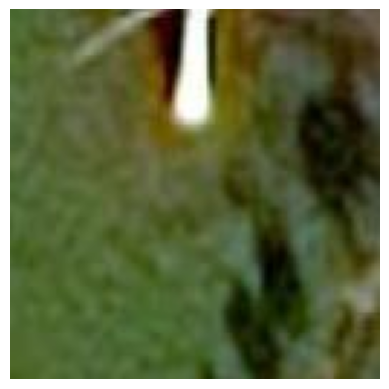

In [3]:
# Chemin d'accès aux données dans Google Drive
data_dir = './Data_Projet_1_Defi_IA/Data_Projet_1_Defi_IA'
#data_dir = '/content/drive/MyDrive/Small'

# Chargement de l'image avec PIL
img_path = data_dir + '/train/target/C254372785.jpg'
img = Image.open(img_path)

# Afficher l'image
plt.imshow(img)
plt.axis('off')
plt.show()

In [4]:
# Paramètres
nb_classes = 2
batch_size = 32
img_width = 128
img_height = 128


# Définir les transformations pour normaliser les images
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_width, img_height)),  # Redimensionner les images
        transforms.ToTensor(),  # Convertir les images en tenseur PyTorch
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normaliser les images
    ]),
    'val': transforms.Compose([
        transforms.Resize((img_width, img_height)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Charger les ensembles d'entraînement et de validation
train_dataset = datasets.ImageFolder(data_dir + '/train', transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(data_dir + '/validation', transform=data_transforms['val'])

# Créer les DataLoaders pour charger les images par lots
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Obtenir les classes
class_names = train_dataset.classes
print(f"Classes: {class_names}")

Classes: ['other', 'target']


In [5]:
len(train_dataset)

58209

In [7]:
def train_val(model, epo = 5):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss().to(device)
    epochs = epo

    for epoch in range(epochs):
        start_time = time.time()

        print(f"Epoch {epoch+1}/{epochs}")

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()


            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        print(f"Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = val_correct / val_total
        print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_acc:.4f}")

        epoch_duration = ((time.time() - start_time)/60)/60
        print(f"Epoch {epoch+1} took {epoch_duration:.2f} hours\n")

In [12]:
# Batch size 16
class DeeperCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(DeeperCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 64 * 64, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))

        x = x.view(-1, 64 * 64 * 64)


        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

model = DeeperCNN(num_classes=2)
optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()
print(model)

DeeperCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=262144, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = DeeperCNN().to(device)
train_val(model,5)

Using device: cpu
Epoch 1/5
Loss: 0.3365, Accuracy: 0.8529
Validation Loss: 0.2590, Validation Accuracy: 0.9162
Epoch 1 took 0.61 hours

Epoch 2/5
Loss: 0.2152, Accuracy: 0.9129
Validation Loss: 0.1913, Validation Accuracy: 0.9294
Epoch 2 took 0.62 hours

Epoch 3/5
Loss: 0.1873, Accuracy: 0.9265
Validation Loss: 0.1949, Validation Accuracy: 0.9332
Epoch 3 took 0.62 hours

Epoch 4/5
Loss: 0.1741, Accuracy: 0.9333
Validation Loss: 0.1963, Validation Accuracy: 0.9294
Epoch 4 took 0.61 hours

Epoch 5/5
Loss: 0.1613, Accuracy: 0.9363
Validation Loss: 0.1676, Validation Accuracy: 0.9382
Epoch 5 took 0.61 hours



In [14]:
torch.save(model.state_dict(), 'model1.pth')

In [15]:
torch.save(model, 'entire_model1.pth')

In [8]:
# Batch size 32
class DeeperCNN2(nn.Module):
    def __init__(self, num_classes=2):
        super(DeeperCNN2, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)


        self.pool = nn.MaxPool2d(2, 2)


        self.fc1 = nn.Linear(128 * 32 * 32, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)


        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))


        x = x.view(-1, 128 * 32 * 32)


        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


model2 = DeeperCNN2(num_classes=2)
optimizer = optim.Adam(model2.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
print(model2)

DeeperCNN2(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model2 = DeeperCNN2().to(device)
train_val(model2,5)

Using device: cpu
Epoch 1/5
Loss: 0.1831, Accuracy: 0.9345
Validation Loss: 0.1312, Validation Accuracy: 0.9508
Epoch 1 took 1.63 hours

Epoch 2/5
Loss: 0.1171, Accuracy: 0.9589
Validation Loss: 0.1241, Validation Accuracy: 0.9548
Epoch 2 took 1.43 hours

Epoch 3/5
Loss: 0.0895, Accuracy: 0.9686
Validation Loss: 0.1236, Validation Accuracy: 0.9580
Epoch 3 took 1.36 hours

Epoch 4/5
Loss: 0.0711, Accuracy: 0.9756
Validation Loss: 0.1520, Validation Accuracy: 0.9598
Epoch 4 took 1.43 hours

Epoch 5/5
Loss: 0.0527, Accuracy: 0.9829
Validation Loss: 0.1752, Validation Accuracy: 0.9590
Epoch 5 took 1.31 hours



In [10]:
torch.save(model2.state_dict(), 'complex_model.pth')

In [11]:
torch.save(model2, 'entire_complex_model.pth')